## Comparison

#### Preambule

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_7960\688568299.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Data reading

In [3]:
xr_dataread = xr.open_dataset("K:/ECEMF/T5.2/xr_dataread_pbl.nc")
xr_2030 = xr.open_dataset("K:/ECEMF/T5.2/xr_alloc_2030.nc")

In [4]:
df_berg = pd.read_excel(Path("X:/user/dekkerm/Data/") / "Berg_paper" / "Berg2019_data.xlsx", sheet_name = "Emission pathways")
df_berg2 = df_berg[(df_berg.Scenario == 'Gt400') & (df_berg.Category == 'Emissions|Kyoto Gases')].drop(columns=['Scenario', 'Fixed variable', 'Category', 'Unnamed: 10',  'Unnamed: 12', 'Region #'])
df_berg2 = df_berg2.rename({'Sensitivity case': "Parameters", 'Year': 'Time'}, axis=1)
approaches = np.array(df_berg2.Approach)
approaches[approaches == 'IEPC'] = 'PC'
df_berg2['Approach'] = approaches
df_berg2 = df_berg2.melt(id_vars=["Approach", "Region", "Parameters", "Time"], var_name="Range", value_name="Value")
df_berg2 = df_berg2.set_index(['Approach', "Region", "Parameters", "Range", "Time"])
xr_berg = df_berg2.to_xarray()

In [5]:
df_rob = pd.read_excel(Path("X:/user/dekkerm/Data/") / "Robiou_paper" / "Robiou2016_15data.xlsx", sheet_name = "1.5°C National allocations")
df_rob2 = df_rob.drop(columns=['Country names', 'INDC Low assessment', 'INDC average assessment', 'INDC High assessment', 2025, '2025.1', '2030.1', 2040, '2040.1', 2050, '2050.1', 'Peaking year', 'First net-zero allocation year', 'Budget 2010-2050', 'Budget 2010-2100'])
df_rob2 = df_rob2.rename({'Country code ISO Alpha-3': 'Region', "approaches names": "Approach", 2030:'Val2030wrt2010'}, axis=1)
approaches = np.array(df_rob2.Approach)
approaches[approaches == 'CER'] = 'GF'
approaches[approaches == 'EPC'] = 'PCC'
approaches[approaches == 'CAP'] = 'AP'
approaches[approaches == 'CPC'] = 'ECPC'
df_rob2['Approach'] = approaches
df_rob2 = df_rob2.set_index(['Approach', 'Region'])
xr_rob = df_rob2.to_xarray()

In [6]:
df_raj = pd.read_csv(Path("X:/user/dekkerm/Data/") / "Rajamani_paper" / "Data.csv")
df_raj2 = df_raj[df_raj.keys()[[1, -1, -2]]]
df_raj2 = df_raj2.rename({'ISO3': 'Region', 'Full literature range maximum 2030 [% of 2010]': 'Maximum_2030wrt2010', 'Full literature range minimum 2030 [% of 2010]' : 'Minimum_2030wrt2010'}, axis=1)
df_raj3 = df_raj2.melt(id_vars=["Region"], var_name="Variable", value_name="Value")
df_raj3 = df_raj3.set_index(['Variable', 'Region'])
xr_raj = df_raj3.to_xarray()

In [7]:
all_countries_iso = np.load(Path("K:/ECEMF/T5.2/") / "all_countries.npy", allow_pickle=True)

AR6

In [8]:
df_ar6_raw = pd.read_csv("X:/user/dekkerm/Data/IPCC/AR6_Scenarios_Database_World_v1.1.csv")

In [9]:
df_ar6 = df_ar6_raw[df_ar6_raw.Variable.isin(['Emissions|Kyoto Gases', 'Emissions|CO2', 'Emissions|CH4', 'Emissions|N2O', 'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile'])]
df_ar6 = df_ar6.reset_index(drop=True)

df_ar6_meta = pd.read_excel("X:/user/dekkerm/Data/IPCC/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx", sheet_name='meta_Ch3vetted_withclimate')
mods = np.array(df_ar6_meta.Model)
scens = np.array(df_ar6_meta.Scenario)
modscens_meta = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6_meta['ModelScenario'] = modscens_meta
df_ar6_meta = df_ar6_meta[['ModelScenario', 'Category', 'Policy_category']]

df_ar6_meta_c1 = df_ar6_meta[df_ar6_meta.Category.isin(['C1'])]
df_ar6_meta_c1 = df_ar6_meta_c1.reset_index(drop=True)
ms_c1 = np.array(df_ar6_meta_c1.ModelScenario)

df_ar6_meta_c2 = df_ar6_meta[df_ar6_meta.Category.isin(['C2'])]
df_ar6_meta_c2 = df_ar6_meta_c2.reset_index(drop=True)
ms_c2 = np.array(df_ar6_meta_c2.ModelScenario)

df_ar6_meta_c3 = df_ar6_meta[df_ar6_meta.Category.isin(['C3'])]
df_ar6_meta_c3 = df_ar6_meta_c3.reset_index(drop=True)
ms_c3 = np.array(df_ar6_meta_c3.ModelScenario)

mods = np.array(df_ar6.Model)
scens = np.array(df_ar6.Scenario)
modscens = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6['ModelScenario'] = modscens
df_ar6 = df_ar6.drop(['Model', 'Scenario', 'Unit', 'Region'], axis=1)

In [10]:
dummy = df_ar6.melt(id_vars=["Variable", "ModelScenario"], var_name="Time", value_name="Value")
dummy['Time'] = np.array(dummy['Time'].astype(int))
dummy = dummy.set_index(["Variable", "ModelScenario", "Time"])
xr_scen = xr.Dataset.from_dataframe(dummy)
xr_scen = xr_scen.reindex(Time = np.arange(1990, 2101))
xr_scen = xr_scen.interpolate_na(dim="Time", method="linear")

In [15]:
ar = np.array(xr_scen.sel(ModelScenario=ms_c1, Variable = 'Emissions|CO2', Time = np.arange(2021, 2101)).Value)
ar[ar < 0] = 0

In [30]:
np.mean(ar.sum(axis=1)/1e3)

489.01981737408266

(array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  0.,
         3.,  1.,  2.,  1.,  1.,  0.,  4.,  5.,  8.,  4.,  1.,  2.,  2.,
         5.,  2., 21.,  5.,  2.,  2.,  3.,  3.,  2.,  1.,  1.,  1.,  1.,
         1.,  2.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([176.38394732, 188.29778269, 200.21161807, 212.12545344,
        224.03928882, 235.95312419, 247.86695957, 259.78079494,
        271.69463032, 283.60846569, 295.52230107, 307.43613644,
        319.34997181, 331.26380719, 343.17764256, 355.09147794,
        367.00531331, 378.91914869, 390.83298406, 402.74681944,
        414.66065481, 426.57449019, 438.48832556, 450.40216094,
        462.31599631, 474.22983168, 486.14366706, 498.05750243,
        509.97133781, 521.88517318, 533.79900856, 545.71284393,
        557.62667931, 569.54051468, 581.45435006, 593.36818543,
        605.28202081, 617.19585618, 629.10969155, 641.02352693,
        652.9373623 , 664.85119768, 676.76503305, 688.67886843,
        700.

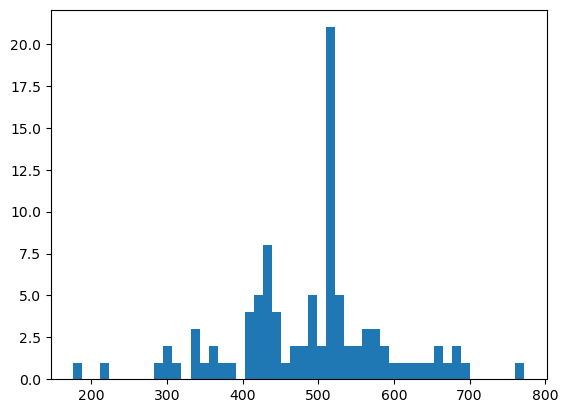

In [27]:
plt.hist(ar.sum(axis=1)/1e3, bins=50)

In [10]:
def ms_temp(T):
    peaktemp = xr_scen.sel(Variable = 'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile').Value.max(dim='Time')
    return xr_scen.ModelScenario[np.where((peaktemp < T+0.05) & (peaktemp > T-0.05))[0]]

Forster

In [11]:
df_budgets = pd.read_csv("X:/user/dekkerm/Data/Budgets_Forster2023/ClimateIndicator-data-ed37002/data/carbon_budget/updateMAGICCscen_temp2013_2022-budget.csv")
df_budgets = df_budgets[["dT_targets", "0.1", "0.17", "0.33", "0.5", "0.66", "0.83", '0.9']]
dummy = df_budgets.melt(id_vars=["dT_targets"], var_name="Probability", value_name="Budget")
ar = np.array(dummy['Probability'])
ar = ar.astype(float).round(2)
ar[ar == 0.66] = 0.67
dummy['Probability'] = ar
dummy['dT_targets'] = dummy['dT_targets'].astype(float).round(1)
dummy = dummy.set_index(["dT_targets", "Probability"])
dummy['Budget'] = dummy['Budget'] + float(xr_dataread.sel(Region='EARTH', Time=2021).CO2_hist)/1e3 + 40.9 # from Forster 2023 for the year 2022 -> 1 Jan 2021 as starting year! So not + float(self.xr_primap.sel(Region='EARTH', Time=2020).CO2_hist)/1e3 
xr_bud_co2 = xr.Dataset.from_dataframe(dummy)
xr_bud_co2 = xr_bud_co2.rename({'dT_targets': "Temperature"}).sel(Temperature = [1.5, 1.7, 2.0])

### Comparison of CO2 budgets

In [12]:
ar6_years = []
ar6_cumco2 = []
ar6_temps = []
peaktemp = xr_scen.sel(Variable = 'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile').Value.max(dim='Time')

for ms_i, ms in enumerate(xr_scen.ModelScenario):
    wh = np.where(xr_scen.sel(Variable = 'Emissions|CO2', ModelScenario=ms).Value <= 0)[0]
    if len(wh) > 0:
        year = float(xr_scen.Time[wh[0]])
        ar6_years.append(year)
        ar6_cumco2.append(float(xr_scen.sel(Variable = 'Emissions|CO2', ModelScenario=ms, Time = np.arange(2021, year)).sum(dim='Time').Value))
    else:
        ar6_years.append(np.nan)
        ar6_cumco2.append(np.nan)
    ar6_temps.append(float(peaktemp.sel(ModelScenario=ms)))
    if ms_i == 305: print(year, ar6_cumco2[-1])

2038.0 135869.66604125104


In [13]:
now_temp = float(xr_scen.sel(Variable = 'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile', Time=2021).mean().Value)
now_cumco2 = float(xr_dataread.CO2_hist.sel(Region='EARTH', Time=np.arange(1850, 2021)).sum())

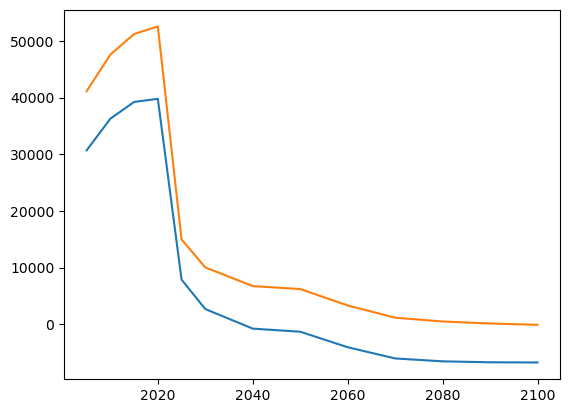

In [14]:
plt.plot(xr_scen.Time, xr_scen.sel(Variable = 'Emissions|CO2', ModelScenario=xr_scen.ModelScenario[305]).Value)
plt.plot(xr_scen.Time, xr_scen.sel(Variable = 'Emissions|Kyoto Gases', ModelScenario=xr_scen.ModelScenario[305]).Value)

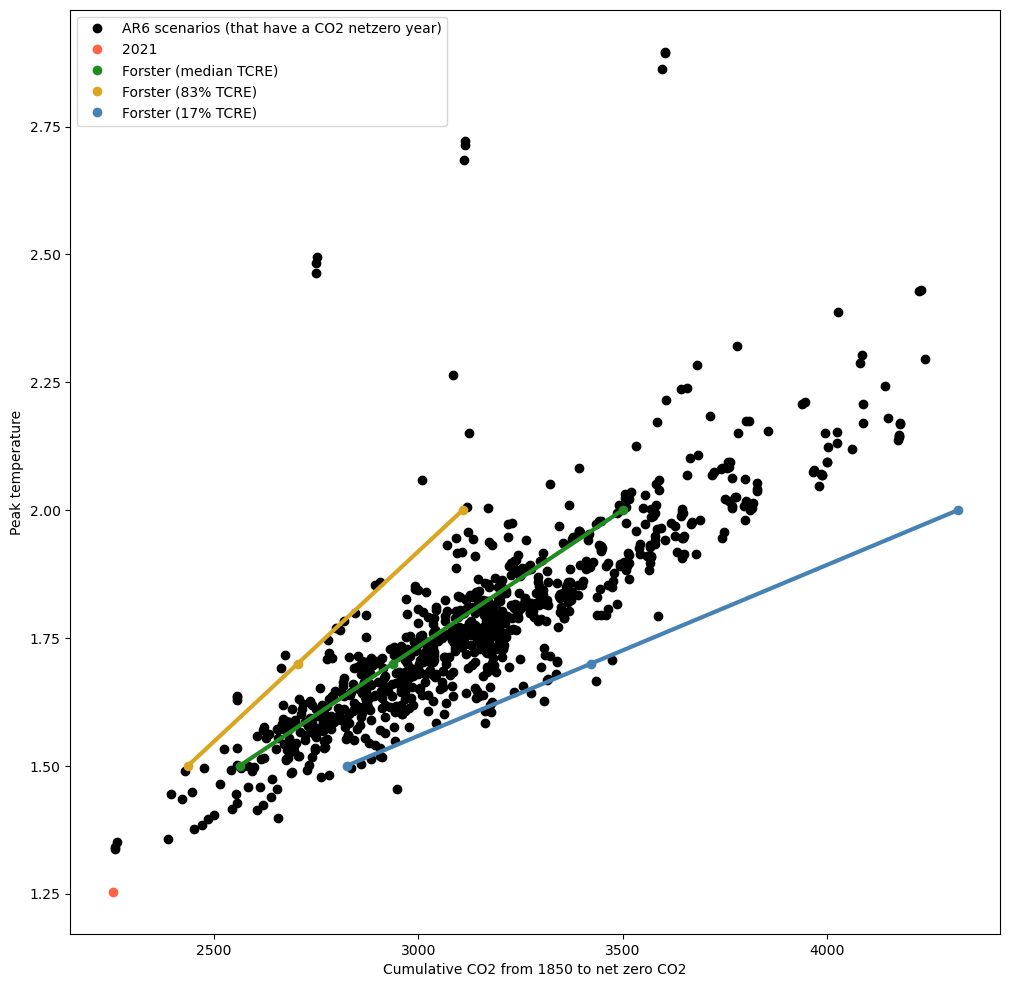

In [15]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot((now_cumco2+np.array(ar6_cumco2))/1e3, ar6_temps, 'ok', label='AR6 scenarios (that have a CO2 netzero year)')

ax.plot(now_cumco2/1e3, now_temp, 'o', c='tomato', label='2021')

ax.plot(xr_bud_co2.Budget.sel(Probability=0.5)+now_cumco2/1e3, xr_bud_co2.Temperature, 'o', c='forestgreen', label='Forster (median TCRE)')
ax.plot(xr_bud_co2.Budget.sel(Probability=0.5)+now_cumco2/1e3, xr_bud_co2.Temperature, lw=3, c='forestgreen')

ax.plot(xr_bud_co2.Budget.sel(Probability=0.83)+now_cumco2/1e3, xr_bud_co2.Temperature, 'o', c='goldenrod', label='Forster (83% TCRE)')
ax.plot(xr_bud_co2.Budget.sel(Probability=0.83)+now_cumco2/1e3, xr_bud_co2.Temperature, lw=3, c='goldenrod')

ax.plot(xr_bud_co2.Budget.sel(Probability=0.17)+now_cumco2/1e3, xr_bud_co2.Temperature, 'o', c='steelblue', label='Forster (17% TCRE)')
ax.plot(xr_bud_co2.Budget.sel(Probability=0.17)+now_cumco2/1e3, xr_bud_co2.Temperature, lw=3, c='steelblue')

ax.set_xlabel("Cumulative CO2 from 1850 to net zero CO2")
ax.set_ylabel("Peak temperature")
plt.legend()

In [1]:
np.nanmean(np.array(ar6_cumco2)[(np.array(ar6_temps) > 1.5) & (np.array(ar6_temps) < 1.6)])

NameError: name 'np' is not defined

In [24]:
xr_bud_co2.Budget.sel(Probability=0.5)

<xarray.DataArray 'Budget' (Temperature: 3)>
array([ 310.66002593,  685.11757217, 1246.86050494])
Coordinates:
  * Temperature  (Temperature) float64 1.5 1.7 2.0
    Probability  float64 0.5

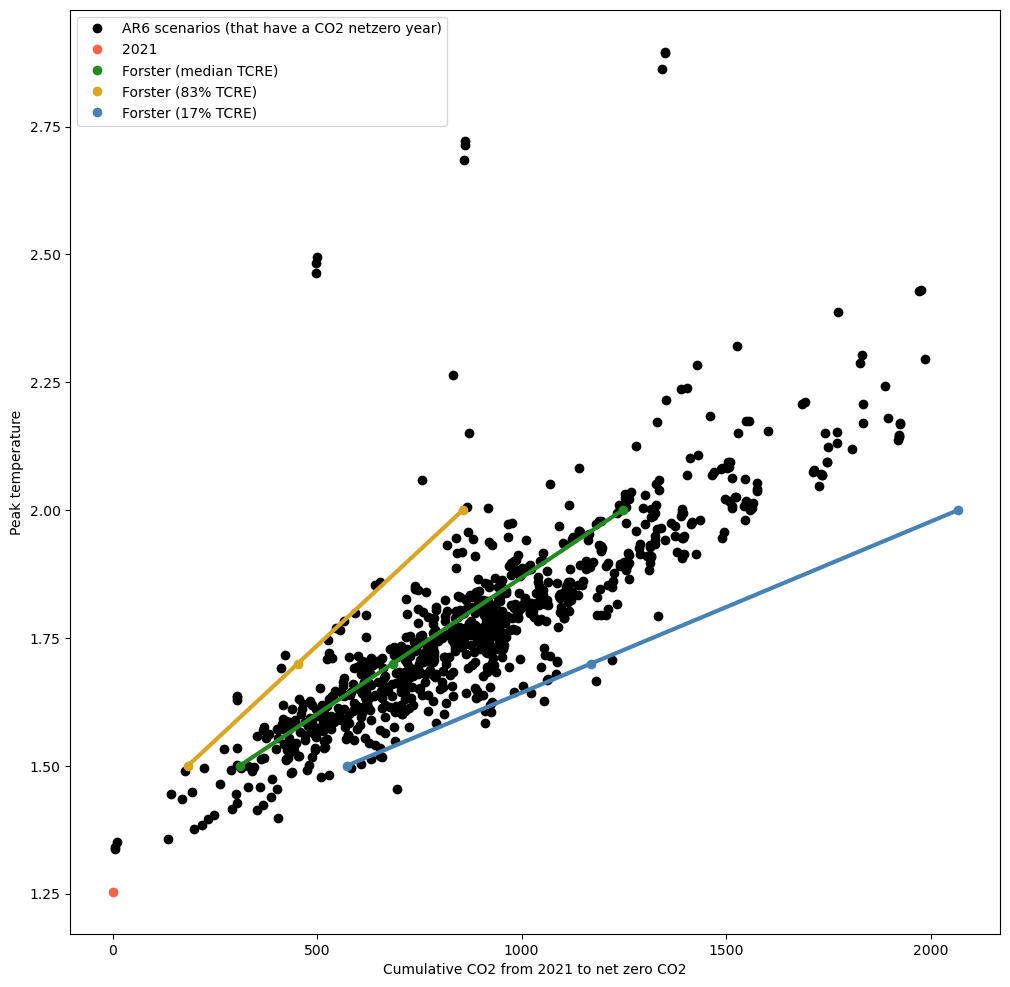

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot((0+np.array(ar6_cumco2))/1e3, ar6_temps, 'ok', label='AR6 scenarios (that have a CO2 netzero year)')

ax.plot(0, now_temp, 'o', c='tomato', label='2021')

ax.plot(xr_bud_co2.Budget.sel(Probability=0.5), xr_bud_co2.Temperature, 'o', c='forestgreen', label='Forster (median TCRE)')
ax.plot(xr_bud_co2.Budget.sel(Probability=0.5), xr_bud_co2.Temperature, lw=3, c='forestgreen')

ax.plot(xr_bud_co2.Budget.sel(Probability=0.83), xr_bud_co2.Temperature, 'o', c='goldenrod', label='Forster (83% TCRE)')
ax.plot(xr_bud_co2.Budget.sel(Probability=0.83), xr_bud_co2.Temperature, lw=3, c='goldenrod')

ax.plot(xr_bud_co2.Budget.sel(Probability=0.17), xr_bud_co2.Temperature, 'o', c='steelblue', label='Forster (17% TCRE)')
ax.plot(xr_bud_co2.Budget.sel(Probability=0.17), xr_bud_co2.Temperature, lw=3, c='steelblue')

ax.set_xlabel("Cumulative CO2 from 2021 to net zero CO2")
ax.set_ylabel("Peak temperature")
plt.legend()

### Comparison of allocations

Check the minima of the range within GF, PCC, GDR and AP for any given country (cty):

In [75]:
vary = ['GF', 'PCC', 'GDR', 'AP']
cty = 'IND'

# Own work
val_2005 = float(xr_dataread.GHG_hist.sel(Time=2010, Region=cty))
val_year = np.array(xr_2030.sel(Temperature=1.5, Risk=0.5, NegEmis=0.5, Timing='Immediate', NonCO2red=0.5, Region=cty, Convergence_year=2050).mean(dim=['Scenario'])[vary].to_array())
print('Own work:',np.round(np.min((val_year - val_2005)/val_2005), 3))

# Berg
try:
    val_2010 = np.array(xr_berg.sel(Approach=vary, Range='default', Region=cty, Time=2010).mean(dim='Parameters').Value)
    val_year = np.array(xr_berg.sel(Approach=vary, Range='default', Region=cty, Time=2030).mean(dim='Parameters').Value)
    print('Berg:',np.round(np.min((val_year - val_2010)/val_2010), 3))
except:
    3

# Robiou
val_yearwrt2010 = np.array(xr_rob.sel(Approach=vary, Region=cty).Val2030wrt2010/100)
print('Robiou (excl LULUCF):',np.round(np.min(val_yearwrt2010), 3))

# Raj
val = 1-float(xr_raj.sel(Variable = 'Minimum_2030wrt2010', Region=cty).Value)/100
print('Rajamani (excl LULUCF):',np.round(-val, 3))

Own work: -0.188
Berg: -0.315
Robiou (excl LULUCF): -0.33
Rajamani (excl LULUCF): -0.188


Also check the maximum allocation (all in 2030 wrt 2010):

In [74]:
vary = ['GF', 'PCC', 'GDR', 'AP']
cty = 'NLD'

# Own work
val_2005 = float(xr_dataread.GHG_hist.sel(Time=2010, Region=cty))
val_year = np.array(xr_2030.sel(Temperature=1.5, Risk=0.5, NegEmis=0.5, Timing='Immediate', NonCO2red=0.5, Region=cty, Convergence_year=2050).mean(dim=['Scenario'])[vary].to_array()) #Timing='Immediate',  , NonCO2red=0.5
print('Own work:',np.round(np.max((val_year - val_2005)/val_2005), 3))

# Berg
try:
    val_2010 = np.array(xr_berg.sel(Approach=vary, Range='default', Region=cty, Time=2010).mean(dim='Parameters').Value)
    val_year = np.array(xr_berg.sel(Approach=vary, Range='default', Region=cty, Time=2030).mean(dim='Parameters').Value)
    print('Berg:',np.round(np.max((val_year - val_2010)/val_2010), 3))
except:
    3

# Robiou
val_yearwrt2010 = np.array(xr_rob.sel(Approach=vary, Region=cty).Val2030wrt2010/100)
print('Robiou (excl LULUCF):',np.round(np.max(val_yearwrt2010), 3))

# Raj
val = 1-float(xr_raj.sel(Variable = 'Maximum_2030wrt2010', Region=cty).Value)/100
print('Rajamani (excl LULUCF):',np.round(-val, 3))

Own work: -0.53
Robiou (excl LULUCF): -0.33
Rajamani (excl LULUCF): -0.391


Per allocation rule (Rajamani does not provide this):

In [76]:
cty = 'BRA'

for vary in ['GF', 'PCC', 'AP', 'GDR', 'ECPC']:
    print('=========', vary, '=========')
    # Own work
    val_2005 = xr_dataread.GHG_hist.sel(Time=2010, Region=cty)
    val_year = xr_2030.sel(Temperature=1.5, Risk=0.5, NegEmis=0.5, Timing='Immediate', NonCO2red=0.5, Region=cty, Convergence_year=2050).mean(dim=['Scenario'])[vary] #Timing='Immediate',  , NonCO2red=0.5
    print('Own work:',np.round(float((val_year - val_2005)/val_2005), 3))

    # Berg
    try:
        val_2010 = xr_berg.sel(Approach=vary, Range='default', Region=cty, Time=2010).mean(dim='Parameters').Value
        val_year = xr_berg.sel(Approach=vary, Range='default', Region=cty, Time=2030).mean(dim='Parameters').Value
        print('Berg:',np.round(float((val_year - val_2010)/val_2010), 3))
    except:
        3

    # Robiou
    val_yearwrt2010 = float(xr_rob.sel(Approach=vary, Region=cty).Val2030wrt2010/100)
    print('Robiou (excl LULUCF):',np.round(val_yearwrt2010, 3))
    print('')

========= GF =========
Own work: -0.559
Berg: -0.315
Robiou (excl LULUCF): -0.33

========= PCC =========
Own work: -0.581
Berg: -0.439
Robiou (excl LULUCF): -0.29

========= AP =========
Own work: -0.558
Berg: -0.382
Robiou (excl LULUCF): -0.54

========= GDR =========
Own work: -0.449
Berg: -0.388
Robiou (excl LULUCF): -0.28

========= ECPC =========
Own work: -0.747
Robiou (excl LULUCF): -0.39

